In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas as pd
import re
import plotly.express as px
from scipy import stats
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Read in Maxquant output and split experiment channels

evidence_df = pd.read_csv('evidence_G1arrest.txt', delimiter='\t')
df = evidence_df

evidence_df_1 = evidence_df.loc[df['Experiment'] == 1]
evidence_df_2 = evidence_df.loc[df['Experiment'] == 2]
evidence_df_3 = evidence_df.loc[df['Experiment'] == 3]

evidence_df_1

,Sequence,Length,K Count,R Count,Modifications,Modified sequence,Oxidation (M) Probabilities,Oxidation (M) Score Diffs,Acetyl (Protein N-term),Oxidation (M),...,Reverse,Potential contaminant,id,Protein group IDs,Peptide ID,Mod. peptide ID,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Taxonomy IDs
1,AAAAEKNVPLYQHLADLSK,19,2,0,Unmodified,_AAAAEKNVPLYQHLADLSK_,NaN,NaN,0,0,...,NaN,NaN,1,157,0,0,2;3,2,NaN,NaN
2,AAAAEKNVPLYQHLADLSK,19,2,0,Unmodified,_AAAAEKNVPLYQHLADLSK_,NaN,NaN,0,0,...,NaN,NaN,2,157,0,0,4;5,5,NaN,NaN
3,AAAAEKNVPLYQHLADLSK,19,2,0,Unmodified,_AAAAEKNVPLYQHLADLSK_,NaN,NaN,0,0,...,NaN,NaN,3,157,0,0,6,6,NaN,NaN
9,AAAAGAGGAGDSGDAVTK,18,1,0,Unmodified,_AAAAGAGGAGDSGDAVTK_,NaN,NaN,0,0,...,NaN,NaN,9,1919,1,1,18,18,NaN,NaN
14,AAAAGAGGAGDSGDAVTK,18,1,0,Unmodified,_AAAAGAGGAGDSGDAVTK_,NaN,NaN,0,0,...,NaN,NaN,14,1919,1,1,23,23,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647173,YYYTLHVTPEK,11,1,0,Unmodified,_YYYTLHVTPEK_,NaN,NaN,0,0,...,NaN,NaN,647173,663,67655,75688,1386487;1386488,1386488,NaN,NaN
647174,YYYTLHVTPEK,11,1,0,Unmodified,_YYYTLHVTPEK_,NaN,NaN,0,0,...,NaN,NaN,647174,663,67655,75688,1386489,1386489,NaN,NaN
647175,YYYTLHVTPEK,11,1,0,Unmodified,_YYYTLHVTPEK_,NaN,NaN,0,0,...,NaN,NaN,647175,663,67655,75688,1386490;1386491,1386491,NaN,NaN
647176,YYYTLHVTPEK,11,1,0,Unmodified,_YYYTLHVTPEK_,NaN,NaN,0,0,...,NaN,NaN,647176,663,67655,75688,1386492,1386492,NaN,NaN


In [3]:
# 
#
# Filtering Experiment ALL (defining base dataframes)
#
#

df_all = evidence_df[['Sequence', 'Modified sequence', 'Charge', 'Fraction', 'Missed cleavages', 'Modifications', 'Type', 'Proteins', 'Leading proteins', 
          'Leading razor protein', 'Labeling State', 'Raw file', 'Score', 'Retention time', 
          'Retention length', 'MS/MS count',
          'Intensity', 'Intensity L', 'Intensity M', 'Intensity H']]


# removing CON_ and REV_

df_all_2 = df_all.loc[~df_all['Leading razor protein'].str.contains('CON_')]
df_all_2 = df_all_2.loc[~df_all_2['Leading razor protein'].str.contains('REV_')]
df_all_2.reset_index(inplace = True, drop = True)

# Quantified experimental peptide only

df_all_3 = df_all_2.dropna(subset=['Intensity'])
df_all_4 = df_all_3.loc[~df_all_3['Proteins'].str.contains('CON_')]


print("Total Protein IDs:" , df_all['Leading razor protein'].nunique())
print("Protein IDs after REV_ and CON_ filtering:" , df_all_2['Leading razor protein'].nunique())
print("Proteins with Quantitation:" , df_all_3['Leading razor protein'].nunique())
print('\n')
print("Total Peptide IDs:" , df_all['Sequence'].count())
print("Peptide IDs after REV_ and CON_ filtering:" , df_all_2['Sequence'].count())
print("Peptides with Quantitation:" , df_all_3['Sequence'].count())
print('\n')
print("Total PSMs:" , df_all['MS/MS count'].sum())
print("Peptide PSMs after REV_ and CON_ filtering:" , df_all_2['MS/MS count'].sum())
print("Peptide PSMs with Quantitation:" , df_all_3['MS/MS count'].sum())

Total Protein IDs: 4369
Protein IDs after REV_ and CON_ filtering: 4262
Proteins with Quantitation: 4256


Total Peptide IDs: 647195
Peptide IDs after REV_ and CON_ filtering: 644908
Peptides with Quantitation: 608740


Total PSMs: 1386528
Peptide PSMs after REV_ and CON_ filtering: 1382208
Peptide PSMs with Quantitation: 1345640


In [4]:
# 
#
# Filtering Experiment #1 (defining base dataframes)
#
#

df_1_1 = evidence_df_1[['Sequence', 'Modified sequence', 'Charge', 'Fraction', 'Missed cleavages', 'Modifications', 'Type', 'Proteins', 'Leading proteins', 
          'Leading razor protein', 'Labeling State', 'Raw file', 'Score', 'Retention time', 
          'Retention length', 'MS/MS count',
          'Intensity', 'Intensity L', 'Intensity M', 'Intensity H']]


# removing CON_ and REV_

df_1_2 = df_1_1.loc[~df_1_1['Leading razor protein'].str.contains('CON_')]
df_1_2 = df_1_2.loc[~df_1_2['Leading razor protein'].str.contains('REV_')]
df_1_2.reset_index(inplace = True, drop = True)

# Quantified experimental peptide only

df_1_3 = df_1_2.dropna(subset=['Intensity'])
df_1_4 = df_1_3.loc[~df_1_3['Proteins'].str.contains('CON_')]


print("Total Protein IDs:" , df_1_1['Leading razor protein'].nunique())
print("Protein IDs after REV_ and CON_ filtering:" , df_1_2['Leading razor protein'].nunique())
print("Proteins with Quantitation:" , df_1_3['Leading razor protein'].nunique())
print('\n')
print("Total Peptide IDs:" , df_1_1['Sequence'].count())
print("Peptide IDs after REV_ and CON_ filtering:" , df_1_2['Sequence'].count())
print("Peptides with Quantitation:" , df_1_3['Sequence'].count())
print('\n')
print("Total PSMs:" , df_1_1['MS/MS count'].sum())
print("Peptide PSMs after REV_ and CON_ filtering:" , df_1_2['MS/MS count'].sum())
print("Peptide PSMs with Quantitation:" , df_1_3['MS/MS count'].sum())

Total Protein IDs: 4291
Protein IDs after REV_ and CON_ filtering: 4211
Proteins with Quantitation: 4192


Total Peptide IDs: 210482
Peptide IDs after REV_ and CON_ filtering: 209761
Peptides with Quantitation: 197771


Total PSMs: 449470
Peptide PSMs after REV_ and CON_ filtering: 448102
Peptide PSMs with Quantitation: 435995


In [5]:
# 
#
# Filtering Experiment #2 (defining base dataframes)
#
#

df_2_1 = evidence_df_2[['Sequence', 'Modified sequence', 'Charge', 'Fraction', 'Missed cleavages', 'Modifications', 'Type', 'Proteins', 'Leading proteins', 
          'Leading razor protein', 'Labeling State', 'Raw file', 'Score', 'Retention time', 
          'Retention length', 'MS/MS count',
          'Intensity', 'Intensity L', 'Intensity M', 'Intensity H']]


# removing CON_ and REV_

df_2_2 = df_2_1.loc[~df_2_1['Leading razor protein'].str.contains('CON_')]
df_2_2 = df_2_2.loc[~df_2_2['Leading razor protein'].str.contains('REV_')]
df_2_2.reset_index(inplace = True, drop = True)

# Quantified experimental peptide only

df_2_3 = df_2_2.dropna(subset=['Intensity'])
df_2_4 = df_2_3.loc[~df_2_3['Proteins'].str.contains('CON_')]


print("Total Protein IDs:" , df_2_1['Leading razor protein'].nunique())
print("Protein IDs after REV_ and CON_ filtering:" , df_2_2['Leading razor protein'].nunique())
print("Proteins with Quantitation:" , df_2_3['Leading razor protein'].nunique())
print('\n')
print("Total Peptide IDs:" , df_2_1['Sequence'].count())
print("Peptide IDs after REV_ and CON_ filtering:" , df_2_2['Sequence'].count())
print("Peptides with Quantitation:" , df_2_3['Sequence'].count())
print('\n')
print("Total PSMs:" , df_2_1['MS/MS count'].sum())
print("Peptide PSMs after REV_ and CON_ filtering:" , df_2_2['MS/MS count'].sum())
print("Peptide PSMs with Quantitation:" , df_2_3['MS/MS count'].sum())

Total Protein IDs: 4312
Protein IDs after REV_ and CON_ filtering: 4227
Proteins with Quantitation: 4216


Total Peptide IDs: 220193
Peptide IDs after REV_ and CON_ filtering: 219385
Peptides with Quantitation: 207328


Total PSMs: 472495
Peptide PSMs after REV_ and CON_ filtering: 470957
Peptide PSMs with Quantitation: 458764


In [6]:
# 
#
# Filtering Experiment #3 (defining base dataframes)
#
#


df_3_1 = evidence_df_3[['Sequence', 'Modified sequence', 'Charge', 'Fraction', 'Missed cleavages', 'Modifications', 'Type', 'Proteins', 'Leading proteins', 
          'Leading razor protein', 'Labeling State', 'Raw file', 'Score', 'Retention time', 
          'Retention length', 'MS/MS count',
          'Intensity', 'Intensity L', 'Intensity M', 'Intensity H']]


# removing CON_ and REV_

df_3_2 = df_3_1.loc[~df_3_1['Leading razor protein'].str.contains('CON_')]
df_3_2 = df_3_2.loc[~df_3_2['Leading razor protein'].str.contains('REV_')]
df_3_2.reset_index(inplace = True, drop = True)

# Quantified experimental peptide only

df_3_3 = df_3_2.dropna(subset=['Intensity'])
df_3_4 = df_3_3.loc[~df_3_3['Proteins'].str.contains('CON_')]


print("Total Protein IDs:" , df_3_1['Leading razor protein'].nunique())
print("Protein IDs after REV_ and CON_ filtering:" , df_3_2['Leading razor protein'].nunique())
print("Proteins with Quantitation:" , df_3_3['Leading razor protein'].nunique())
print('\n')
print("Total Peptide IDs:" , df_3_1['Sequence'].count())
print("Peptide IDs after REV_ and CON_ filtering:" , df_3_2['Sequence'].count())
print("Peptides with Quantitation:" , df_3_3['Sequence'].count())
print('\n')
print("Total PSMs:" , df_3_1['MS/MS count'].sum())
print("Peptide PSMs after REV_ and CON_ filtering:" , df_3_2['MS/MS count'].sum())
print("Peptide PSMs with Quantitation:" , df_3_3['MS/MS count'].sum())

Total Protein IDs: 4319
Protein IDs after REV_ and CON_ filtering: 4231
Proteins with Quantitation: 4219


Total Peptide IDs: 216520
Peptide IDs after REV_ and CON_ filtering: 215762
Peptides with Quantitation: 203641


Total PSMs: 464563
Peptide PSMs after REV_ and CON_ filtering: 463149
Peptide PSMs with Quantitation: 450881


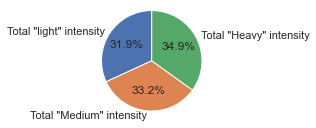

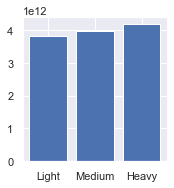

In [7]:
#
# Summed channel intensities - Experiment #1
#

sns.set(rc={'figure.figsize':(2,2)})


# Summed Channel Intensities (No possible CON_ peptides)

Light = df_1_4['Intensity L'].sum()
Medium = df_1_4['Intensity M'].sum()
Heavy = df_1_4['Intensity H'].sum()

labels = 'Total "light" intensity' , 'Total "Medium" intensity' , 'Total "Heavy" intensity'  
sizes = [Light , Medium, Heavy]
explode = (0, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
       startangle=90)
ax1.axis('equal')

plt.show()


# Bar Chart

L = df_1_4['Intensity L'].sum()
M = df_1_4['Intensity M'].sum()
H = df_1_4['Intensity H'].sum()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Light', 'Medium', 'Heavy']
students = [L, M, H]
ax.bar(langs,students)
# fig.savefig('Intensity_1.pdf', dp1=300)
plt.show()

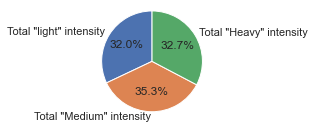

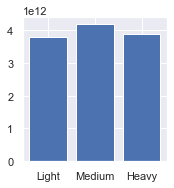

In [8]:
#
# Summed channel intensities - Experiment #2
#

sns.set(rc={'figure.figsize':(2,2)})

# Summed Channel Intensities (No possible CON_ peptides)

Light = df_2_4['Intensity L'].mean()
Medium = df_2_4['Intensity M'].mean()
Heavy = df_2_4['Intensity H'].mean()

labels = 'Total "light" intensity' , 'Total "Medium" intensity' , 'Total "Heavy" intensity'  
sizes = [Light , Medium, Heavy]
explode = (0, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
       startangle=90)
ax1.axis('equal')

plt.show()

# Bar Chart

L = df_2_4['Intensity L'].sum()
M = df_2_4['Intensity M'].sum()
H = df_2_4['Intensity H'].sum()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Light', 'Medium', 'Heavy']
students = [L, M, H]
ax.bar(langs,students)
# fig.savefig('Intensity_1.pdf', dp1=300)
plt.show()

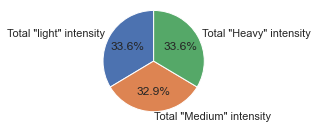

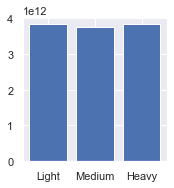

In [9]:
#
# Summed channel intensities - Experiment #3
#

# Summed Channel Intensities (No possible CON_ peptides)

Light = df_3_4['Intensity L'].sum()
Medium = df_3_4['Intensity M'].sum()
Heavy = df_3_4['Intensity H'].sum()

labels = 'Total "light" intensity' , 'Total "Medium" intensity' , 'Total "Heavy" intensity'  
sizes = [Light , Medium, Heavy]
explode = (0, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
       startangle=90)
ax1.axis('equal')

plt.show()

# Bar Chart

L = df_3_4['Intensity L'].sum()
M = df_3_4['Intensity M'].sum()
H = df_3_4['Intensity H'].sum()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Light', 'Medium', 'Heavy']
students = [L, M, H]
ax.bar(langs,students)
# fig.savefig('Intensity_1.pdf', dp1=300)
plt.show()

In [10]:
#
# Calculating SILAC triplet proportionality - Experiment #1, 2, and 3 (and trimming the edges)
#

# Experiment #1 

df_1_4['IntensityFraction_L'] = df_1_4['Intensity L'] / df_1_4['Intensity']
df_1_4['IntensityFraction_M'] = df_1_4['Intensity M'] / df_1_4['Intensity']
df_1_4['IntensityFraction_H'] = df_1_4['Intensity H'] / df_1_4['Intensity']
df_1_5 = df_1_4

df_1_6 = df_1_5.loc[(df_1_5['Intensity L'] > 0) & (df_1_5['Intensity M'] > 0) & (df_1_5['Intensity H'] > 0)]
df_1_7 = df_1_6.loc[(df_1_6['IntensityFraction_L'] < 0.8) & (df_1_6['IntensityFraction_M'] < 0.8) & (df_1_6['IntensityFraction_H'] < 0.8)]

# Experiment #2

df_2_4['IntensityFraction_L'] = df_2_4['Intensity L'] / df_2_4['Intensity']
df_2_4['IntensityFraction_M'] = df_2_4['Intensity M'] / df_2_4['Intensity']
df_2_4['IntensityFraction_H'] = df_2_4['Intensity H'] / df_2_4['Intensity']
df_2_5 = df_2_4

df_2_6 = df_2_5.loc[(df_2_5['Intensity L'] > 0) & (df_2_5['Intensity M'] > 0) & (df_2_5['Intensity H'] > 0)]
df_2_7 = df_2_6.loc[(df_2_5['IntensityFraction_L'] < 0.8) & (df_2_6['IntensityFraction_M'] < 0.8) & (df_2_6['IntensityFraction_H'] < 0.8)]

# Experiment #3

df_3_4['IntensityFraction_L'] = df_3_4['Intensity L'] / df_3_4['Intensity']
df_3_4['IntensityFraction_M'] = df_3_4['Intensity M'] / df_3_4['Intensity']
df_3_4['IntensityFraction_H'] = df_3_4['Intensity H'] / df_3_4['Intensity']
df_3_5 = df_3_4

df_3_6 = df_3_5.loc[(df_3_5['Intensity L'] > 0) & (df_3_5['Intensity M'] > 0) & (df_3_5['Intensity H'] > 0)]
df_3_7 = df_3_6.loc[(df_3_5['IntensityFraction_L'] < 0.8) & (df_3_6['IntensityFraction_M'] < 0.8) & (df_3_6['IntensityFraction_H'] < 0.8)]

print("Experiment #1")
print("All triplets:" , len(df_1_5))
print("After zeros removed:" , len(df_1_6))
print("After single channel removed:" , len(df_1_7))
print('\n')
print("Experiment #2")
print("All triplets:" , len(df_2_5))
print("After zeros removed:" , len(df_2_6))
print("After single channel removed:" , len(df_2_7))
print('\n')
print("Experiment #3")
print("All triplets:" , len(df_2_5))
print("After zeros removed:" , len(df_2_6))
print("After single channel removed:" , len(df_2_7))
print('\n')

Experiment #1
All triplets: 197771
After zeros removed: 197162
After single channel removed: 195952


Experiment #2
All triplets: 207328
After zeros removed: 206719
After single channel removed: 205426


Experiment #3
All triplets: 207328
After zeros removed: 206719
After single channel removed: 205426




In [11]:
#
# Before normalization
#

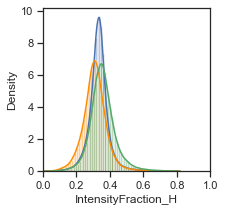

Experiment #1 - fraction of ion intensity in each SILAC channel
Mean
Light: 0.3333958220501394
Medium: 0.31008710537908707
Heavy: 0.356517072094239


Median
Light: 0.33228101967714274
Medium: 0.3086049823595813
Heavy: 0.3512626586751847


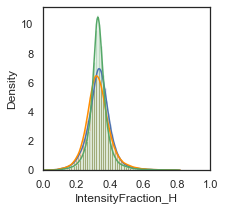

Experiment #2 - fraction of ion intensity in each SILAC channel
Mean
Light: 0.33634101271357203
Medium: 0.3300384172458922
Heavy: 0.3336206014948128


Median
Light: 0.335492177712747
Medium: 0.32526751659962033
Heavy: 0.33004631566880926


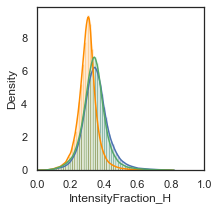

Experiment #3 - fraction of ion intensity in each SILAC channel
Mean
Light: 0.3537001133741628
Medium: 0.30398198342454125
Heavy: 0.34231792916658454


Median
Light: 0.34868172563500044
Medium: 0.30300795917906354
Heavy: 0.3409321611195737


In [12]:
# Intensity fraction distribution - Experiment #1

sns.set(rc={'figure.figsize':(3,3)})
sns.set_style('ticks')

L = df_1_7['IntensityFraction_L']
M = df_1_7['IntensityFraction_M']
H = df_1_7['IntensityFraction_H']

sns.distplot(L, bins = 75, color = 'b')
sns.distplot(M, bins = 75, color = 'darkorange')
sns.distplot(H, bins = 75, color = 'g')

plt.xlim([0, 1])
# plt.savefig('Channel_dist_raw_1.pdf', dp1=300)
plt.show()

print("Experiment #1 - fraction of ion intensity in each SILAC channel")
print('Mean')
print("Light:" , df_1_7['IntensityFraction_L'].mean())
print("Medium:" , df_1_7['IntensityFraction_M'].mean())
print("Heavy:" , df_1_7['IntensityFraction_H'].mean())
print('\n')
print('Median')
print("Light:" , df_1_7['IntensityFraction_L'].median())
print("Medium:" , df_1_7['IntensityFraction_M'].median())
print("Heavy:" , df_1_7['IntensityFraction_H'].median())


# Intensity fraction distribution - Experiment #2

sns.set_style('white')

L = df_2_7['IntensityFraction_L']
M = df_2_7['IntensityFraction_M']
H = df_2_7['IntensityFraction_H']

sns.distplot(L, bins = 75, color = 'b')
sns.distplot(M, bins = 75, color = 'darkorange')
sns.distplot(H, bins = 75, color = 'g')

plt.xlim([0, 1])
# plt.savefig('Channel_dist_raw_2.pdf', dp1=300)
plt.show()

print("Experiment #2 - fraction of ion intensity in each SILAC channel")
print('Mean')
print("Light:" , df_2_7['IntensityFraction_L'].mean())
print("Medium:" , df_2_7['IntensityFraction_M'].mean())
print("Heavy:" , df_2_7['IntensityFraction_H'].mean())
print('\n')
print('Median')
print("Light:" , df_2_7['IntensityFraction_L'].median())
print("Medium:" , df_2_7['IntensityFraction_M'].median())
print("Heavy:" , df_2_7['IntensityFraction_H'].median())


# Intensity fraction distribution - Experiment #3

sns.set_style('white')

L = df_3_7['IntensityFraction_L']
M = df_3_7['IntensityFraction_M']
H = df_3_7['IntensityFraction_H']

sns.distplot(L, bins = 75, color = 'b')
sns.distplot(M, bins = 75, color = 'darkorange')
sns.distplot(H, bins = 75, color = 'g')

plt.xlim([0, 1])
plt.savefig('Channel_dist_raw_3.pdf', dp1=300)
plt.show()

print("Experiment #3 - fraction of ion intensity in each SILAC channel")
print('Mean')
print("Light:" , df_3_7['IntensityFraction_L'].mean())
print("Medium:" , df_3_7['IntensityFraction_M'].mean())
print("Heavy:" , df_3_7['IntensityFraction_H'].mean())
print('\n')
print('Median')
print("Light:" , df_3_7['IntensityFraction_L'].median())
print("Medium:" , df_3_7['IntensityFraction_M'].median())
print("Heavy:" , df_3_7['IntensityFraction_H'].median())

In [13]:
#
#
# Normalization using the median intensity fraction in each channel - Experiment #1, #2, and #3
#
#


df_1_7['Normalized_IntensityFraction_L'] = df_1_7['IntensityFraction_L'] / df_1_7['IntensityFraction_L'].median()
df_1_7['Normalized_IntensityFraction_M'] = df_1_7['IntensityFraction_M'] / df_1_7['IntensityFraction_M'].median()
df_1_7['Normalized_IntensityFraction_H'] = df_1_7['IntensityFraction_H'] / df_1_7['IntensityFraction_H'].median()


df_2_7['Normalized_IntensityFraction_L'] = df_2_7['IntensityFraction_L'] / df_2_7['IntensityFraction_L'].median()
df_2_7['Normalized_IntensityFraction_M'] = df_2_7['IntensityFraction_M'] / df_2_7['IntensityFraction_M'].median()
df_2_7['Normalized_IntensityFraction_H'] = df_2_7['IntensityFraction_H'] / df_2_7['IntensityFraction_H'].median()


df_3_7['Normalized_IntensityFraction_L'] = df_3_7['IntensityFraction_L'] / df_3_7['IntensityFraction_L'].median()
df_3_7['Normalized_IntensityFraction_M'] = df_3_7['IntensityFraction_M'] / df_3_7['IntensityFraction_M'].median()
df_3_7['Normalized_IntensityFraction_H'] = df_3_7['IntensityFraction_H'] / df_3_7['IntensityFraction_H'].median()



In [14]:
#
# After normalization
#

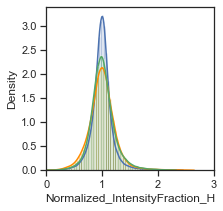

Experiment #1 - fraction of ion intensity in each SILAC channel after median normalization
Mean
1.003354998651683
1.0048026542156694
1.0149586450175823


Median
1.0
1.0
1.0


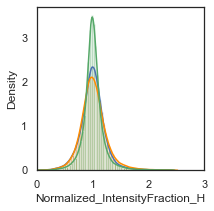

Experiment #2 - fraction of ion intensity in each SILAC channel after median normalization
Mean
1.002530118605483
1.0146676209667276
1.0108296492229


Median
1.0
1.0
1.0


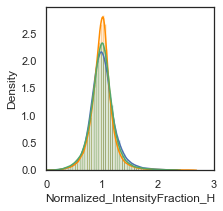

Experiment #3 - fraction of ion intensity in each SILAC channel after median normalization
Mean
1.0143924598572613
1.0032145170315547
1.0040646445394306


Median
1.0
1.0
1.0


In [15]:
# Intensity fraction distribution - Experiment #1


sns.set(rc={'figure.figsize':(3,3)})
sns.set_style('ticks')

L = df_1_7['Normalized_IntensityFraction_L']
M = df_1_7['Normalized_IntensityFraction_M']
H = df_1_7['Normalized_IntensityFraction_H']

sns.distplot(L, bins = 75, color = 'b')
sns.distplot(M, bins = 75, color = 'darkorange')
sns.distplot(H, bins = 75, color = 'g')

plt.xlim([0, 3])
# plt.savefig('Channel_dist_norm_1.pdf', dp1=300)
plt.show()

print("Experiment #1 - fraction of ion intensity in each SILAC channel after median normalization")
print('Mean')
print(df_1_7['Normalized_IntensityFraction_L'].mean())
print(df_1_7['Normalized_IntensityFraction_M'].mean())
print(df_1_7['Normalized_IntensityFraction_H'].mean())
print('\n')
print('Median')
print(df_1_7['Normalized_IntensityFraction_L'].median())
print(df_1_7['Normalized_IntensityFraction_M'].median())
print(df_1_7['Normalized_IntensityFraction_H'].median())



# Intensity fraction distribution - Experiment #2

sns.set_style('white')

L = df_2_7['Normalized_IntensityFraction_L']
M = df_2_7['Normalized_IntensityFraction_M']
H = df_2_7['Normalized_IntensityFraction_H']

sns.distplot(L, bins = 75, color = 'b')
sns.distplot(M, bins = 75, color = 'darkorange')
sns.distplot(H, bins = 75, color = 'g')

plt.xlim([0, 3])
# plt.savefig('Channel_dist_norm_2.pdf', dp1=300)
plt.show()

print("Experiment #2 - fraction of ion intensity in each SILAC channel after median normalization")
print('Mean')
print(df_2_7['Normalized_IntensityFraction_L'].mean())
print(df_2_7['Normalized_IntensityFraction_M'].mean())
print(df_2_7['Normalized_IntensityFraction_H'].mean())
print('\n')
print('Median')
print(df_2_7['Normalized_IntensityFraction_L'].median())
print(df_2_7['Normalized_IntensityFraction_M'].median())
print(df_2_7['Normalized_IntensityFraction_H'].median())



# Intensity fraction distribution - Experiment #3

sns.set_style('white')

L = df_3_7['Normalized_IntensityFraction_L']
M = df_3_7['Normalized_IntensityFraction_M']
H = df_3_7['Normalized_IntensityFraction_H']

sns.distplot(L, bins = 75, color = 'b')
sns.distplot(M, bins = 75, color = 'darkorange')
sns.distplot(H, bins = 75, color = 'g')

plt.xlim([0, 3])
plt.savefig('Channel_dist_norm_3.pdf', dp1=300)
plt.show()

print("Experiment #3 - fraction of ion intensity in each SILAC channel after median normalization")
print('Mean')
print(df_3_7['Normalized_IntensityFraction_L'].mean())
print(df_3_7['Normalized_IntensityFraction_M'].mean())
print(df_3_7['Normalized_IntensityFraction_H'].mean())
print('\n')
print('Median')
print(df_3_7['Normalized_IntensityFraction_L'].median())
print(df_3_7['Normalized_IntensityFraction_M'].median())
print(df_3_7['Normalized_IntensityFraction_H'].median())

In [16]:
#
# LOG2 transformation
#

df_1_7['Normalized_IntensityFraction_L_log2'] = np.log2(df_1_7['Normalized_IntensityFraction_L'])
df_1_7['Normalized_IntensityFraction_M_log2'] = np.log2(df_1_7['Normalized_IntensityFraction_M'])
df_1_7['Normalized_IntensityFraction_H_log2'] = np.log2(df_1_7['Normalized_IntensityFraction_H'])

df_2_7['Normalized_IntensityFraction_L_log2'] = np.log2(df_2_7['Normalized_IntensityFraction_L'])
df_2_7['Normalized_IntensityFraction_M_log2'] = np.log2(df_2_7['Normalized_IntensityFraction_M'])
df_2_7['Normalized_IntensityFraction_H_log2'] = np.log2(df_2_7['Normalized_IntensityFraction_H'])

df_3_7['Normalized_IntensityFraction_L_log2'] = np.log2(df_3_7['Normalized_IntensityFraction_L'])
df_3_7['Normalized_IntensityFraction_M_log2'] = np.log2(df_3_7['Normalized_IntensityFraction_M'])
df_3_7['Normalized_IntensityFraction_H_log2'] = np.log2(df_3_7['Normalized_IntensityFraction_H'])

In [17]:
#
# Peptide slope calculation (used for mean squarred error filtering)
#

In [18]:
#
# Regression - X values are the relative cell size (log2) and Y values are the peptide protein concentration (log2) 
#


# Line fitting using np.polyfit - return the peptide slope and mean squared error for Experiment #1, 2, and 3

# Experiment #1

df_1_fit = pd.DataFrame({'slope': [''],
                       'mean_sqr_error': ['']} , index=df_1_7.index)
slope = []
mean_sqr_error = []
for index, row in df_1_7.iterrows():
    x = [-0.965, -0.136, 0.658]
    y = [row['Normalized_IntensityFraction_M_log2'], 
         row['Normalized_IntensityFraction_L_log2'], 
         row['Normalized_IntensityFraction_H_log2']]
    fit = np.polyfit(x, y, 1, full=True)
    tuple1 = fit[0]
    slope.append(tuple1[0])
    mean_sqr_error.append(fit[1][0])


    
df_1_fit['slope'] = slope
df_1_fit['mean_sqr_error'] = mean_sqr_error


# Experiment #2

df_2_fit = pd.DataFrame({'slope': [''],
                       'mean_sqr_error': ['']} , index=df_2_7.index)

slope = []
mean_sqr_error = []
for index, row in df_2_7.iterrows():
    x = [-0.895, -0.169, 0.653]
    y = [row['Normalized_IntensityFraction_L_log2'], 
         row['Normalized_IntensityFraction_H_log2'], 
         row['Normalized_IntensityFraction_M_log2']]
    fit = np.polyfit(x, y, 1, full=True)
    tuple1 = fit[0]
    slope.append(tuple1[0])
    mean_sqr_error.append(fit[1][0])
    
    
df_2_fit['slope'] = slope
df_2_fit['mean_sqr_error'] = mean_sqr_error


# Experiment #3

df_3_fit = pd.DataFrame({'slope': [''],
                       'mean_sqr_error': ['']} , index=df_3_7.index)

slope = []
mean_sqr_error = []
for index, row in df_3_7.iterrows():
    x = [-0.998, -0.202, 0.705]
    y = [row['Normalized_IntensityFraction_H_log2'], 
         row['Normalized_IntensityFraction_M_log2'], 
         row['Normalized_IntensityFraction_L_log2']]
    fit = np.polyfit(x, y, 1, full=True)
    tuple1 = fit[0]
    slope.append(tuple1[0])
    mean_sqr_error.append(fit[1][0])
    
    
df_3_fit['slope'] = slope
df_3_fit['mean_sqr_error'] = mean_sqr_error

In [19]:
#
# Adding slopes and MSE to primary dataframe - Experiment #1, #2, and #3
#

df_1_8 = df_1_7.join(df_1_fit)
df_2_8 = df_2_7.join(df_2_fit)
df_3_8 = df_3_7.join(df_3_fit)

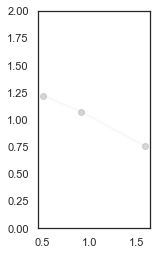

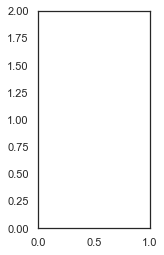

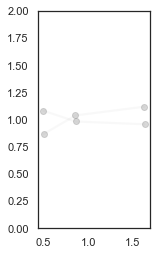

,Sequence,Modified sequence,Charge,Fraction,Missed cleavages,Modifications,Type,Proteins,Leading proteins,Leading razor protein,...,IntensityFraction_M,IntensityFraction_H,Normalized_IntensityFraction_L,Normalized_IntensityFraction_M,Normalized_IntensityFraction_H,Normalized_IntensityFraction_L_log2,Normalized_IntensityFraction_M_log2,Normalized_IntensityFraction_H_log2,slope,mean_sqr_error
37411,ELPPLVVETYLDLR,_ELPPLVVETYLDLR_,2,4,0,Unmodified,MULTI-MSMS,sp|Q06628|ATG13_YEAST,sp|Q06628|ATG13_YEAST,sp|Q06628|ATG13_YEAST,...,0.297688,0.368619,0.956990,0.982442,1.081209,-0.063424,-0.025556,0.112645,-0.101963,0.002081
75178,IGLSKPIINTYSNALNESNLPAHLDQK,_IGLSKPIINTYSNALNESNLPAHLDQK_,4,6,1,Unmodified,MULTI-MSMS,sp|Q06628|ATG13_YEAST,sp|Q06628|ATG13_YEAST,sp|Q06628|ATG13_YEAST,...,0.314612,0.295392,1.118503,1.038295,0.866424,0.161569,0.054217,-0.206855,0.214074,0.005257


In [71]:
#
# regplots for specific proteins
#

gene = "ATG13_YEAST"


# Experiment 1

df_Protein = df_1_8.loc[(df_1_8['Leading razor protein'].str.contains(gene))
                      & (df_1_8['mean_sqr_error'] < .1)]

sns.set(rc={'figure.figsize':(2,4)})
sns.set_style('white')
for index, row in df_Protein.iterrows():
    x = [0.51, .91, 1.58]
    y = [row['Normalized_IntensityFraction_M'], 
         row['Normalized_IntensityFraction_L'], 
         row['Normalized_IntensityFraction_H']]
    g = sns.regplot(x=x,y=y, fit_reg=True, ci=False, scatter_kws={'alpha':0.3}, 
                line_kws={'alpha':0.05}, lowess=True, color = 'gray', x_jitter = 0.01)
    
plt.ylim([0, 2])
plt.show()


# Experiment 2

df_Protein = df_2_8.loc[(df_2_8['Leading razor protein'].str.contains(gene))
                      & (df_2_8['mean_sqr_error'] < .1)]

sns.set(rc={'figure.figsize':(2,4)})
sns.set_style('white')
for index, row in df_Protein.iterrows():
    x = [0.54, .89, 1.57]
    y = [row['Normalized_IntensityFraction_L'], 
         row['Normalized_IntensityFraction_H'], 
         row['Normalized_IntensityFraction_M']]
    g = sns.regplot(x=x,y=y, fit_reg=True, ci=False, scatter_kws={'alpha':0.3}, 
                line_kws={'alpha':0.05}, lowess=True, color = 'gray', x_jitter = 0.01)
    
plt.ylim([0, 2])
plt.show()


# Experiment 3

df_Protein = df_3_8.loc[(df_3_8['Leading razor protein'].str.contains(gene))
                      & (df_3_8['mean_sqr_error'] < .1)]

sns.set(rc={'figure.figsize':(2,4)})
sns.set_style('white')
for index, row in df_Protein.iterrows():
    x = [0.5, .86, 1.63]
    y = [row['Normalized_IntensityFraction_H'], 
         row['Normalized_IntensityFraction_M'], 
         row['Normalized_IntensityFraction_L']]
    g = sns.regplot(x=x,y=y, fit_reg=True, ci=False, scatter_kws={'alpha':0.3}, 
                line_kws={'alpha':0.05}, lowess=True, color = 'gray', x_jitter = 0.01)
    
plt.ylim([0, 2])
plt.show()
df_Protein

In [21]:
#
# Peptide-level combined analysis
#

In [22]:
#
# Filter out noisy triplets by mean squared error value
#

Mean_squared_error = 0.2

df_1_9 = df_1_8.loc[(df_1_8['mean_sqr_error'] < Mean_squared_error)]
df_2_9 = df_2_8.loc[(df_2_8['mean_sqr_error'] < Mean_squared_error)]
df_3_9 = df_3_8.loc[(df_3_8['mean_sqr_error'] < Mean_squared_error)]


#
# Unique Identifiers for each peptide-level measurement
#

df_charge_1 = df_1_9['Charge'].astype(str)
df_charge_2 = df_2_9['Charge'].astype(str)
df_charge_3 = df_3_9['Charge'].astype(str)

df_fraction_1 = df_1_9['Fraction'].astype(str)
df_fraction_2 = df_2_9['Fraction'].astype(str)
df_fraction_3 = df_3_9['Fraction'].astype(str)

df_1_9['UniqID'] = df_1_9['Modified sequence'] + 'c' + df_charge_1 + '_' + 'f' + df_fraction_1 + '_' + df_1_9['Leading razor protein']
df_2_9['UniqID'] = df_2_9['Modified sequence'] + 'c' + df_charge_2 + '_' + 'f' + df_fraction_2 + '_' + df_2_9['Leading razor protein']
df_3_9['UniqID'] = df_3_9['Modified sequence'] + 'c' + df_charge_3 + '_' + 'f' + df_fraction_3 + '_' + df_3_9['Leading razor protein']


#
# groupby - Unique Identifiers
#

df_1_gb_mean = df_1_9.groupby(['UniqID']).mean()
df_2_gb_mean = df_2_9.groupby(['UniqID']).mean()
df_3_gb_mean = df_3_9.groupby(['UniqID']).mean()



df_1_uID = df_1_gb_mean.rename(columns={'slope': 'slope_1', 
                                        'mean_sqr_error': 'mean_sqr_error_1', 
                                        'Normalized_IntensityFraction_L':'Normalized_IntensityFraction_L_1',
                                        'Normalized_IntensityFraction_M':'Normalized_IntensityFraction_M_1',
                                        'Normalized_IntensityFraction_H':'Normalized_IntensityFraction_H_1',
                                        'Intensity L': 'Intensity_medium_exp1',
                                        'Intensity M': 'Intensity_small_exp1',
                                        'Intensity H': 'Intensity_large_exp1'})

df_2_uID = df_2_gb_mean.rename(columns={'slope': 'slope_2', 
                                        'mean_sqr_error': 'mean_sqr_error_2', 
                                        'Normalized_IntensityFraction_L':'Normalized_IntensityFraction_L_2',
                                        'Normalized_IntensityFraction_M':'Normalized_IntensityFraction_M_2',
                                        'Normalized_IntensityFraction_H':'Normalized_IntensityFraction_H_2',
                                        'Intensity L': 'Intensity_small_exp2',
                                        'Intensity M': 'Intensity_large_exp2',
                                        'Intensity H': 'Intensity_medium_exp2'})

df_3_uID = df_3_gb_mean.rename(columns={'slope': 'slope_3', 
                                        'mean_sqr_error': 'mean_sqr_error_3', 
                                        'Normalized_IntensityFraction_L':'Normalized_IntensityFraction_L_3',
                                        'Normalized_IntensityFraction_M':'Normalized_IntensityFraction_M_3',
                                        'Normalized_IntensityFraction_H':'Normalized_IntensityFraction_H_3',
                                        'Intensity L': 'Intensity_large_exp3',
                                        'Intensity M': 'Intensity_medium_exp3',
                                        'Intensity H': 'Intensity_small_exp3'})


#
# Simplify dataframe
#

df_1_uID_slopes = df_1_uID[['slope_1', 'mean_sqr_error_1', 
                                        'Normalized_IntensityFraction_L_1', 
                                        'Normalized_IntensityFraction_M_1',
                                        'Normalized_IntensityFraction_H_1',
                                        'Intensity_small_exp1',
                                        'Intensity_medium_exp1',
                                        'Intensity_large_exp1']]

df_2_uID_slopes = df_2_uID[['slope_2', 'mean_sqr_error_2', 
                                        'Normalized_IntensityFraction_L_2', 
                                        'Normalized_IntensityFraction_M_2',
                                        'Normalized_IntensityFraction_H_2',
                                        'Intensity_small_exp2',
                                        'Intensity_medium_exp2',
                                        'Intensity_large_exp2']]

df_3_uID_slopes = df_3_uID[['slope_3', 'mean_sqr_error_3', 
                                        'Normalized_IntensityFraction_L_3', 
                                        'Normalized_IntensityFraction_M_3',
                                        'Normalized_IntensityFraction_H_3',
                                        'Intensity_small_exp3',
                                        'Intensity_medium_exp3',
                                        'Intensity_large_exp3']]


combined_SILAC = pd.concat([df_1_uID_slopes, df_2_uID_slopes, df_3_uID_slopes], axis=1, sort=False)
combined_SILAC = combined_SILAC.reset_index()

print("Peptide triplets for Exp #1:", len(df_1_uID_slopes))
print("Peptide triplets for Exp #2:", len(df_2_uID_slopes))
print("Peptide triplets for Exp #3:", len(df_3_uID_slopes))
print("Total unique triplets:", len(combined_SILAC))

Peptide triplets for Exp #1: 153825
Peptide triplets for Exp #2: 162640
Peptide triplets for Exp #3: 155537
Total unique triplets: 213575


In [23]:
#
# Begin protein-level assembly
#

In [24]:
# 
# Groupby into Protein level dataframe
#

split = combined_SILAC['UniqID'].str.rsplit(pat='|', n=1, expand=True)
combined_SILAC['Protein'] = split[1]
combined_SILAC

combined_SILAC_protein_mean = combined_SILAC.groupby(['Protein']).mean()
combined_SILAC_protein_median = combined_SILAC.groupby(['Protein']).median()
combined_SILAC_protein_std = combined_SILAC.groupby(['Protein']).std()
combined_SILAC_protein_var = combined_SILAC.groupby(['Protein']).var()
combined_SILAC_protein_sum = combined_SILAC.groupby(['Protein']).sum()
combined_SILAC_protein_count = combined_SILAC.groupby(['Protein']).count()


#
# Concat the Protein-level dataframe
#

combined_SILAC_protein_median = combined_SILAC_protein_median.drop(['slope_1', 'slope_2', 'slope_3',
                                                                    'mean_sqr_error_1', 
                                                                    'mean_sqr_error_2',
                                                                    'mean_sqr_error_3',
                                                                    'Intensity_small_exp1',
                                                                    'Intensity_medium_exp1',
                                                                    'Intensity_large_exp1',
                                                                    'Intensity_small_exp2',
                                                                    'Intensity_medium_exp2',
                                                                    'Intensity_large_exp2',
                                                                    'Intensity_small_exp3',
                                                                    'Intensity_medium_exp3',
                                                                    'Intensity_large_exp3'], axis=1)

Protein_level_df = pd.concat([combined_SILAC_protein_count['UniqID'], 
                              combined_SILAC_protein_count['slope_1'],
                              combined_SILAC_protein_count['slope_2'],
                              combined_SILAC_protein_count['slope_3'],
                              combined_SILAC_protein_sum['Intensity_small_exp1'],
                              combined_SILAC_protein_sum['Intensity_small_exp2'],
                              combined_SILAC_protein_sum['Intensity_small_exp3'],
                              combined_SILAC_protein_sum['Intensity_medium_exp1'],
                              combined_SILAC_protein_sum['Intensity_medium_exp2'],
                              combined_SILAC_protein_sum['Intensity_medium_exp3'],
                              combined_SILAC_protein_sum['Intensity_large_exp1'],
                              combined_SILAC_protein_sum['Intensity_large_exp2'],
                              combined_SILAC_protein_sum['Intensity_large_exp3'], 
                              combined_SILAC_protein_median],
                              axis=1)


Protein_level_df = Protein_level_df.dropna()
Protein_level_df


,UniqID,slope_1,slope_2,slope_3,Intensity_small_exp1,Intensity_small_exp2,Intensity_small_exp3,Intensity_medium_exp1,Intensity_medium_exp2,Intensity_medium_exp3,...,Intensity_large_exp3,Normalized_IntensityFraction_L_1,Normalized_IntensityFraction_M_1,Normalized_IntensityFraction_H_1,Normalized_IntensityFraction_L_2,Normalized_IntensityFraction_M_2,Normalized_IntensityFraction_H_2,Normalized_IntensityFraction_L_3,Normalized_IntensityFraction_M_3,Normalized_IntensityFraction_H_3
Protein,,,,,,,,,,,,,,,,,,,,,
2A5D_YEAST,54,40,42,33,5.788910e+07,6.548827e+07,6.078301e+07,7.815010e+07,7.115136e+07,5.906734e+07,...,8.215501e+07,1.021595,0.824419,1.164511,0.879955,1.089112,1.025077,1.155936,0.991684,0.871134
2AAA_YEAST,77,51,55,54,3.225920e+08,2.690973e+08,2.667476e+08,3.368149e+08,2.474694e+08,2.448004e+08,...,2.686800e+08,0.994238,1.056596,0.967763,1.007872,1.001349,0.983445,0.983158,1.041308,0.973745
2ABA_YEAST,45,29,26,28,7.094828e+07,6.083854e+07,6.004691e+07,7.171824e+07,5.436118e+07,4.858968e+07,...,5.986874e+07,0.971868,1.066040,0.990584,1.069477,0.989412,0.954976,1.009310,0.964421,1.051457
2NDP_YEAST,25,19,16,12,2.968031e+07,2.570564e+07,4.901286e+08,3.791175e+07,2.903636e+07,6.028358e+08,...,5.028740e+08,0.981756,0.776390,1.191862,0.841573,1.209600,0.987957,1.215775,0.910650,0.790359
3HAO_YEAST,81,58,67,58,1.912166e+08,2.522817e+08,2.356999e+08,3.196882e+08,3.283084e+08,2.914094e+08,...,5.555866e+08,0.952657,0.612154,1.398368,0.729432,1.338614,0.933994,1.478121,0.862883,0.648334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZPR1_YEAST,234,163,194,186,2.435646e+09,2.903542e+09,3.266316e+09,2.329971e+09,2.567243e+09,2.636905e+09,...,2.574140e+09,0.999923,1.165309,0.878585,1.114309,0.888939,1.013184,0.868472,1.025864,1.118603
ZRC1_YEAST,27,20,19,21,1.321720e+08,1.839270e+08,1.924975e+08,1.329838e+08,1.671653e+08,1.620355e+08,...,1.673105e+08,1.069476,1.087338,0.872813,1.135816,0.890873,1.010841,0.929689,1.042704,1.084217
ZRG17_YEAST,10,8,6,2,1.185497e+07,8.704680e+06,2.780860e+06,1.396152e+07,7.903890e+06,2.130210e+06,...,1.698310e+06,1.100575,1.002689,0.934605,1.041923,1.002807,0.994702,0.701855,1.034533,1.295821


In [25]:
# log transformation 

Protein_level_df['Normalized_IntensityFraction_L_1_log2'] = np.log2(Protein_level_df['Normalized_IntensityFraction_L_1'])
Protein_level_df['Normalized_IntensityFraction_M_1_log2'] = np.log2(Protein_level_df['Normalized_IntensityFraction_M_1'])
Protein_level_df['Normalized_IntensityFraction_H_1_log2'] = np.log2(Protein_level_df['Normalized_IntensityFraction_H_1'])

Protein_level_df['Normalized_IntensityFraction_L_2_log2'] = np.log2(Protein_level_df['Normalized_IntensityFraction_L_2'])
Protein_level_df['Normalized_IntensityFraction_M_2_log2'] = np.log2(Protein_level_df['Normalized_IntensityFraction_M_2'])
Protein_level_df['Normalized_IntensityFraction_H_2_log2'] = np.log2(Protein_level_df['Normalized_IntensityFraction_H_2'])

Protein_level_df['Normalized_IntensityFraction_L_3_log2'] = np.log2(Protein_level_df['Normalized_IntensityFraction_L_3'])
Protein_level_df['Normalized_IntensityFraction_M_3_log2'] = np.log2(Protein_level_df['Normalized_IntensityFraction_M_3'])
Protein_level_df['Normalized_IntensityFraction_H_3_log2'] = np.log2(Protein_level_df['Normalized_IntensityFraction_H_3'])

In [26]:
#
# Protein Slope calculation
#

In [27]:
#
# Regression - X values are the relative cell size (log2) and Y values are the relative protein concentration (log2) 
#


# Line fitting using np.polyfit - return the slope and mean squared error for each protein

Protein_df_fit_1 = pd.DataFrame({'slope_1_ProtCalc': [''],
                       'mean_sqr_error_1_ProtCalc': ['']} , index = Protein_level_df.index)
Protein_df_fit_2 = pd.DataFrame({'slope_2_ProtCalc': [''],
                       'mean_sqr_error_2_ProtCalc': ['']} , index = Protein_level_df.index)
Protein_df_fit_3 = pd.DataFrame({'slope_3_ProtCalc': [''],
                       'mean_sqr_error_3_ProtCalc': ['']} , index = Protein_level_df.index)
slope_1_ProtCalc = []
mean_sqr_error_1_ProtCalc = []
slope_2_ProtCalc = []
mean_sqr_error_2_ProtCalc = []
slope_3_ProtCalc = []
mean_sqr_error_3_ProtCalc = []

for index, row in Protein_level_df.iterrows():
    x_1 = [-0.965, -0.136, 0.658]
    x_2 = [-0.895, -0.169, 0.653]
    x_3 = [-0.998, -0.202, 0.705]
    y_1 = [row['Normalized_IntensityFraction_M_1_log2'], row['Normalized_IntensityFraction_L_1_log2'], row['Normalized_IntensityFraction_H_1_log2']]
    y_2 = [row['Normalized_IntensityFraction_L_2_log2'], row['Normalized_IntensityFraction_H_2_log2'], row['Normalized_IntensityFraction_M_2_log2']]
    y_3 = [row['Normalized_IntensityFraction_H_3_log2'], row['Normalized_IntensityFraction_M_3_log2'], row['Normalized_IntensityFraction_L_3_log2']]
    fit = np.polyfit(x_1, y_1, 1, full=True)
    tuple1 = fit[0]
    slope_1_ProtCalc.append(tuple1[0])
    mean_sqr_error_1_ProtCalc.append(fit[1][0])
    fit = np.polyfit(x_2, y_2, 1, full=True)
    tuple1 = fit[0]
    slope_2_ProtCalc.append(tuple1[0])
    mean_sqr_error_2_ProtCalc.append(fit[1][0])
    fit = np.polyfit(x_3, y_3, 1, full=True)
    tuple1 = fit[0]
    slope_3_ProtCalc.append(tuple1[0])
    mean_sqr_error_3_ProtCalc.append(fit[1][0])
    
    
Protein_df_fit_1['slope_1_ProtCalc'] = slope_1_ProtCalc
Protein_df_fit_1['mean_sqr_error_1_ProtCalc'] = mean_sqr_error_1_ProtCalc

Protein_df_fit_2['slope_2_ProtCalc'] = slope_2_ProtCalc
Protein_df_fit_2['mean_sqr_error_2_ProtCalc'] = mean_sqr_error_2_ProtCalc

Protein_df_fit_3['slope_3_ProtCalc'] = slope_3_ProtCalc
Protein_df_fit_3['mean_sqr_error_3_ProtCalc'] = mean_sqr_error_3_ProtCalc

#
# Concat protein-level dataframe with slope values
#

Protein_df_fit = pd.concat([Protein_level_df, Protein_df_fit_1, Protein_df_fit_2, Protein_df_fit_3], axis=1)

#
# Mean protein slope value
#

Protein_df_fit['Mean_slope_calc'] = ((Protein_df_fit['slope_1_ProtCalc'] 
                                      + Protein_df_fit['slope_2_ProtCalc'] 
                                      + Protein_df_fit['slope_3_ProtCalc']) / 3)

df_std = Protein_df_fit[['slope_1_ProtCalc', 'slope_2_ProtCalc', 'slope_3_ProtCalc']]

Protein_df_fit['Mean_slope_std'] = df_std.std(axis=1)


Protein_df_fit.to_csv('Protein_level_slopes.csv')
Protein_df_fit

,UniqID,slope_1,slope_2,slope_3,Intensity_small_exp1,Intensity_small_exp2,Intensity_small_exp3,Intensity_medium_exp1,Intensity_medium_exp2,Intensity_medium_exp3,...,Normalized_IntensityFraction_M_3_log2,Normalized_IntensityFraction_H_3_log2,slope_1_ProtCalc,mean_sqr_error_1_ProtCalc,slope_2_ProtCalc,mean_sqr_error_2_ProtCalc,slope_3_ProtCalc,mean_sqr_error_3_ProtCalc,Mean_slope_calc,Mean_slope_std
Protein,,,,,,,,,,,,,,,,,,,,,
2A5D_YEAST,54,40,42,33,5.788910e+07,6.548827e+07,6.078301e+07,7.815010e+07,7.115136e+07,5.906734e+07,...,-0.012047,-0.199034,0.307494,0.002006,0.196715,0.003840,0.239729,0.000009,0.247979,0.055848
2AAA_YEAST,77,51,55,54,3.225920e+08,2.690973e+08,2.667476e+08,3.368149e+08,2.474694e+08,2.448004e+08,...,0.058396,-0.038384,-0.078269,0.000354,-0.005224,0.000640,0.005850,0.005428,-0.025881,0.045706
2ABA_YEAST,45,29,26,28,7.094828e+07,6.083854e+07,6.004691e+07,7.171824e+07,5.436118e+07,4.858968e+07,...,-0.052265,0.072390,-0.065959,0.004195,-0.069568,0.008162,-0.032184,0.006273,-0.055904,0.020621
2NDP_YEAST,25,19,16,12,2.968031e+07,2.570564e+07,4.901286e+08,3.791175e+07,2.903636e+07,6.028358e+08,...,-0.135031,-0.339420,0.381202,0.000344,0.338470,0.000132,0.367016,0.004925,0.362229,0.021764
3HAO_YEAST,81,58,67,58,1.912166e+08,2.522817e+08,2.356999e+08,3.196882e+08,3.283084e+08,2.914094e+08,...,-0.212763,-0.625191,0.734565,0.000573,0.567267,0.001952,0.701805,0.013671,0.667879,0.088659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZPR1_YEAST,234,163,194,186,2.435646e+09,2.903542e+09,3.266316e+09,2.329971e+09,2.567243e+09,2.636905e+09,...,0.036839,0.161698,-0.251165,0.000108,-0.211006,0.000163,-0.215582,0.001397,-0.225918,0.021984
ZRC1_YEAST,27,20,19,21,1.321720e+08,1.839270e+08,1.924975e+08,1.329838e+08,1.671653e+08,1.620355e+08,...,0.060329,0.116654,-0.194129,0.012703,-0.226279,0.000010,-0.131467,0.001493,-0.183958,0.048217
ZRG17_YEAST,10,8,6,2,1.185497e+07,8.704680e+06,2.780860e+06,1.396152e+07,7.903890e+06,2.130210e+06,...,0.048980,0.373867,-0.060856,0.023110,-0.034568,0.001120,-0.521706,0.005225,-0.205710,0.273976


In [28]:
#
# Principal component analysis
#

4043
4043
[80.1  6.3  4.7  4.1  2.5  2.   0.2  0.2  0. ]


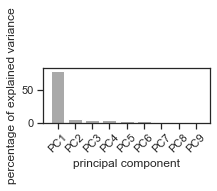

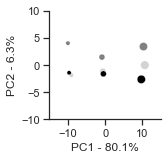

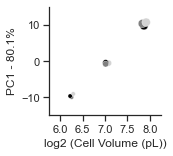

In [29]:
print(len(Protein_df_fit))
forPCA_df = Protein_df_fit.loc[Protein_df_fit['UniqID'] > 0]
print(len(forPCA_df))

def pca_analysis(df_forPCA):
    genes = list(df_forPCA.index.values)
    scaled_data = preprocessing.scale(df_forPCA.T, with_std=False)
    names_list = list(df_forPCA.T.index)
    pca = PCA()
    pca.fit(scaled_data)
    pca_data = pca.transform(scaled_data)
    per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
    labels = ['PC'+ str(x) for x in range(1,len(per_var)+1)]
    pca_df = pd.DataFrame(pca_data, index= names_list, columns= labels )
    loading_scores_1 = pd.Series(pca.components_[0], index= genes)
    loading_scores_2 = pd.Series(pca.components_[1], index= genes)
    
    return(per_var, pca_df , labels, loading_scores_1, loading_scores_2)

forPCA_df = forPCA_df.reset_index()

forPCA_df = forPCA_df[['Protein',
                    'Normalized_IntensityFraction_L_1',
                    'Normalized_IntensityFraction_M_1',
                    'Normalized_IntensityFraction_H_1',
                    'Normalized_IntensityFraction_L_2',
                    'Normalized_IntensityFraction_M_2',
                    'Normalized_IntensityFraction_H_2',
                    'Normalized_IntensityFraction_L_3',
                    'Normalized_IntensityFraction_M_3',
                    'Normalized_IntensityFraction_H_3'
                      ]]

forPCA_df.set_index('Protein', inplace=True)

per_var, pca_df , labels , loading_scores_1 , loading_scores_2 = pca_analysis(forPCA_df)
print(per_var)


#
# Save weight coefficients for individual proteins
#

loading_scores_1.to_csv('loading_scores_pc1.csv')
loading_scores_2.to_csv('loading_scores_pc2.csv')


#
# Features for plotting
#

pca_df['cell_size'] = [135, 76, 234, 
                       78, 228, 129, 
                       242, 129, 74.3
                      ]

pca_df['Experiment #'] = ["Exp #1", "Exp #1", "Exp #1", 
                          "Exp #2", "Exp #2","Exp #2", 
                          "Exp #3", "Exp #3", "Exp #3"
                         ]

pca_df['SILAC_channel'] = ['Light','Medium','Heavy',
                           'Light','Medium', 'Heavy',
                           'Light','Medium', 'Heavy'
                        ]

pca_df['cell_size_log'] = np.log2(pca_df['cell_size'])


#
# Scree plot
#

sns.set(rc={'figure.figsize':(3,1)})
sns.set_style('ticks')

plt.bar(x=range(1,len(per_var)+1),height= per_var, tick_label= labels, color='darkgray')
plt.ylabel('percentage of explained variance')
plt.xlabel('principal component')
plt.xticks(rotation = 45)
plt.savefig('principle_components.pdf', dp1=300, bbox_inches='tight')
plt.show()


#
# PCA plots
#

sns.set(rc={'figure.figsize':(2,2)})
sns.set_style('ticks')

# Create an array with the colors you want to use
colors = ["lightgrey", 'grey', "black" ]
sns.set_palette(sns.color_palette(colors))


# PC1 vs PC2

sns.scatterplot(data=pca_df, x='PC1', y= 'PC2', size = 'cell_size', 
                hue = 'SILAC_channel', legend = False)
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
plt.ylim([-10, 10])
plt.xlim([-15, 15])
plt.locator_params(axis="y", nbins=5)
plt.locator_params(axis="x", nbins=5)
sns.despine()
plt.savefig('PC1_vs_PC2.pdf', dp1=300, bbox_inches='tight')
plt.show()


# PC1 vs cell size (log2)

plt.xlabel("log2 (Cell Volume (pL))")
plt.ylabel('PC1 - {0}%'.format(per_var[0]))
sns.scatterplot(data=pca_df, x='cell_size_log', y='PC1', hue='SILAC_channel', size = 'cell_size', legend=False)
plt.ylim([-15, 15])
plt.xlim([5.75, 8.25])
plt.locator_params(axis="y", nbins=5)
plt.locator_params(axis="x", nbins=5)
sns.despine()
plt.savefig('PC1_vs_Size.pdf', dp1=300, bbox_inches='tight')
plt.show()


In [30]:
#
# Heatmap dataframe
#


Protein_df_fit = Protein_df_fit.sort_values(by='Mean_slope_calc', ascending=False)

clustering_df = Protein_df_fit.loc[(Protein_df_fit['UniqID'] > 2)]


clustering_df = clustering_df[[
                    
                    'Normalized_IntensityFraction_M_1_log2',
                    'Normalized_IntensityFraction_L_2_log2',
                    'Normalized_IntensityFraction_H_3_log2',
                    'Normalized_IntensityFraction_L_1_log2',
                    'Normalized_IntensityFraction_H_2_log2',
                    'Normalized_IntensityFraction_M_3_log2',
                    'Normalized_IntensityFraction_H_1_log2',
                    'Normalized_IntensityFraction_M_2_log2',
                    'Normalized_IntensityFraction_L_3_log2',
                               
                              ]]

# clustering_df = clustering_df.set_index(['Phosphosite'])
print(len(clustering_df))
# clustering_df.to_csv('temp.csv')
clustering_df

3959


,Normalized_IntensityFraction_M_1_log2,Normalized_IntensityFraction_L_2_log2,Normalized_IntensityFraction_H_3_log2,Normalized_IntensityFraction_L_1_log2,Normalized_IntensityFraction_H_2_log2,Normalized_IntensityFraction_M_3_log2,Normalized_IntensityFraction_H_1_log2,Normalized_IntensityFraction_M_2_log2,Normalized_IntensityFraction_L_3_log2
Protein,,,,,,,,,
PHSG_YEAST,-1.869665,-1.780136,-1.941341,-0.494228,-0.508020,-0.617305,0.941917,1.042311,1.026447
GPG1_YEAST,-1.567691,-1.880851,-1.752574,-0.617105,-0.697446,-0.529241,0.994021,1.048284,0.982283
YN94_YEAST,-1.632096,-1.547800,-1.618401,-0.318934,-0.289658,-0.463539,0.870432,0.909884,0.909446
GDE_YEAST,-1.346582,-1.523761,-1.713503,-0.346475,-0.495797,-0.344164,0.781715,0.977397,0.918038
YN95_YEAST,-1.708262,-1.231308,-1.690792,-0.240601,-0.282851,-0.431784,0.817256,0.850937,0.955208
...,...,...,...,...,...,...,...,...,...
ENG1_YEAST,0.918694,0.862347,0.795025,-0.147523,-0.280892,-0.286837,-1.516555,-1.433745,-1.335586
HXT2_YEAST,0.943915,0.827943,0.757774,-0.127504,-0.228747,-0.044825,-1.722444,-1.448559,-1.535062
STDH_YEAST,0.984902,0.888878,0.973171,-0.208672,-0.237535,-0.341596,-1.921126,-1.898844,-2.315030


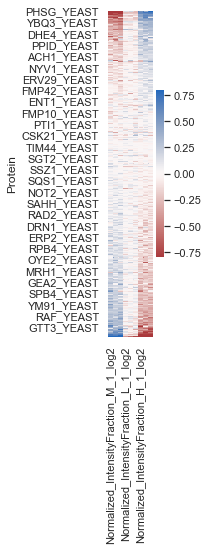

In [31]:
#
# Heatmap
#

sns.set(rc={'figure.figsize':(1,6)})

heatmap_df = clustering_df

sns.heatmap(heatmap_df, 
               vmin=-0.8, vmax=0.8, 
               cmap="vlag_r")

plt.savefig('heatmap.pdf', dp1=300, bbox_inches='tight')

In [32]:
#
# Protein Slopes by abundance quartile
#

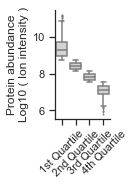

In [33]:
#
# Assigning Quartiles
#

Protein_df_fit['Abundance'] = (Protein_df_fit['Intensity_small_exp1'] +
                                 Protein_df_fit['Intensity_small_exp2'] +
                                 Protein_df_fit['Intensity_small_exp3'])


# Calculate quartiles
quartiles = Protein_df_fit['Abundance'].quantile([0.75, 0.5, 0.25]).values

# Function to assign quartile label
def get_quartile_label(abundance):
    if abundance >= quartiles[0]:
        return "1st Quartile"
    elif abundance >= quartiles[1]:
        return "2nd Quartile"
    elif abundance >= quartiles[2]:
        return "3rd Quartile"
    else:
        return "4th Quartile"

# Add Quartile column to the dataframe
Protein_df_fit['Quartile'] = Protein_df_fit['Abundance'].apply(get_quartile_label)



sns.set(rc={'figure.figsize':(1,2)})
sns.set_style('ticks')


# Set the order
my_order = ['1st Quartile', '2nd Quartile', '3rd Quartile', '4th Quartile']

flierprops = dict(color='gray', markersize=1,
              linestyle='none')

sns.boxplot(y = np.log10(Protein_df_fit['Abundance']), x = Protein_df_fit['Quartile'], 
            order=my_order, flierprops=flierprops, color='lightgray')

plt.xticks(rotation = 45)
sns.despine()
plt.ylabel("Protein abundance\nLog10 ( Ion intensity )")
plt.xlabel("")
plt.savefig('quartiles.pdf', dp1=300, bbox_inches='tight')
plt.show()

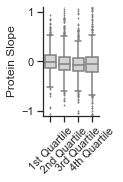

In [34]:
#
# Mean protein slope and distribution in each abundance quartile 
#

flierprops = dict(color='gray', markersize=1,
              linestyle='none')

sns.boxplot(y = Protein_df_fit['Mean_slope_calc'], x = Protein_df_fit['Quartile'], 
            order=my_order, flierprops=flierprops, color='lightgray')
plt.xticks(rotation = 45)
sns.despine()
plt.ylim([-1.1, 1.1])
plt.ylabel("Protein Slope")
plt.xlabel("")
plt.savefig('quartiles_slope.pdf', dp1=300, bbox_inches='tight')
plt.show()

In [35]:
#
#
# Correlation of replicate experiments
#
#

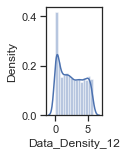

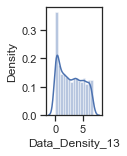

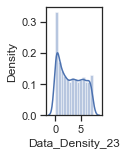

In [36]:
# Calculate the point density - Experiment #1 vs #2
x = Protein_df_fit['slope_1_ProtCalc']
y = Protein_df_fit['slope_2_ProtCalc']

xy = np.vstack([x,y])
Protein_df_fit['Data_Density_12'] = gaussian_kde(xy)(xy)
sns.distplot(Protein_df_fit['Data_Density_12'])
plt.show()


# Calculate the point density - Experiment #1 vs #3
x = Protein_df_fit['slope_1_ProtCalc']
y = Protein_df_fit['slope_3_ProtCalc']

xy = np.vstack([x,y])
Protein_df_fit['Data_Density_13'] = gaussian_kde(xy)(xy)
sns.distplot(Protein_df_fit['Data_Density_13'])
plt.show()


# Calculate the point density - Experiment #2 vs #3
x = Protein_df_fit['slope_2_ProtCalc']
y = Protein_df_fit['slope_3_ProtCalc']

xy = np.vstack([x,y])
Protein_df_fit['Data_Density_23'] = gaussian_kde(xy)(xy)
sns.distplot(Protein_df_fit['Data_Density_23'])
plt.show()

In [37]:
### Color palette

customPalette = sns.dark_palette("silver", reverse=True, as_cmap=True)
alpha = 0.35
sns.set(rc={'figure.figsize':(3.1,3.1)})
tick_size = 15
Protein_df_fit

ymin = -1.9
ymax = 1.9
xmin = -1.9
xmax = 1.9

4043
(0.8453994689290738, 0.0)


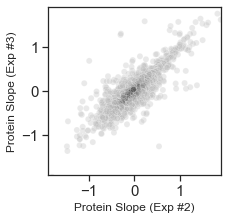

3803
(0.8922256612250352, 0.0)


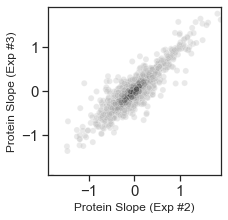

3328
(0.9329395604958226, 0.0)


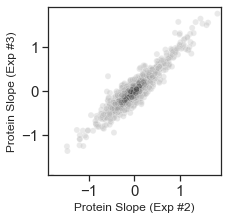

2714
(0.9546221914984896, 0.0)


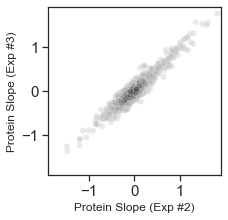

2316
(0.9621677370899133, 0.0)


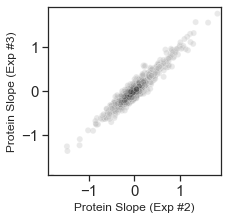

1984
(0.9665302987044528, 0.0)


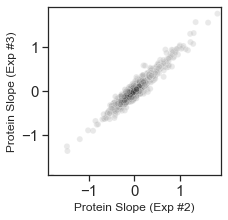

In [38]:
# Scatterplot for annotation

sns.set_style('ticks')
Protein_df_fit_plot = Protein_df_fit.loc[(Protein_df_fit['slope_2'] > 0)
                                         & (Protein_df_fit['slope_3'] > 0)] 


sns.scatterplot(data=Protein_df_fit_plot, x='slope_2_ProtCalc', y='slope_3_ProtCalc', 
                alpha=alpha, legend=False, hue = Protein_df_fit['Data_Density_23'], 
                palette=customPalette)

plt.tick_params(labelsize= tick_size)
plt.xlabel("Protein Slope (Exp #2)")
plt.ylabel("Protein Slope (Exp #3)")
plt.ylim([ymin, ymax])
plt.xlim([ymin, ymax])
print(len(Protein_df_fit_plot))
print(stats.pearsonr(Protein_df_fit_plot['slope_2_ProtCalc'], Protein_df_fit_plot['slope_3_ProtCalc']))
plt.savefig('protein_slopes_all.pdf', dp1=300, bbox_inches='tight')
plt.show()



# Scatterplot for annotation

sns.set_style('ticks')
Protein_df_fit_plot = Protein_df_fit.loc[(Protein_df_fit['slope_2'] > 1)
                                         & (Protein_df_fit['slope_3'] > 1)] 


sns.scatterplot(data=Protein_df_fit_plot, x='slope_2_ProtCalc', y='slope_3_ProtCalc', 
                alpha=alpha, legend=False, hue = Protein_df_fit['Data_Density_23'], 
                palette=customPalette)

plt.tick_params(labelsize= tick_size)
plt.xlabel("Protein Slope (Exp #2)")
plt.ylabel("Protein Slope (Exp #3)")
plt.ylim([ymin, ymax])
plt.xlim([ymin, ymax])
print(len(Protein_df_fit_plot))
print(stats.pearsonr(Protein_df_fit_plot['slope_2_ProtCalc'], Protein_df_fit_plot['slope_3_ProtCalc']))
plt.savefig('protein_slopes_2.pdf', dp1=300, bbox_inches='tight')
plt.show()



# Scatterplot for annotation

sns.set_style('ticks')
Protein_df_fit_plot = Protein_df_fit.loc[(Protein_df_fit['slope_2'] > 3)
                                         & (Protein_df_fit['slope_3'] > 3)] 


sns.scatterplot(data=Protein_df_fit_plot, x='slope_2_ProtCalc', y='slope_3_ProtCalc', 
                alpha=alpha, legend=False, hue = Protein_df_fit['Data_Density_23'], 
                palette=customPalette)

plt.tick_params(labelsize= tick_size)
plt.xlabel("Protein Slope (Exp #2)")
plt.ylabel("Protein Slope (Exp #3)")
plt.ylim([ymin, ymax])
plt.xlim([ymin, ymax])
print(len(Protein_df_fit_plot))
print(stats.pearsonr(Protein_df_fit_plot['slope_2_ProtCalc'], Protein_df_fit_plot['slope_3_ProtCalc']))
plt.savefig('protein_slopes_4.pdf', dp1=300, bbox_inches='tight')
plt.show()



# Scatterplot for annotation

sns.set_style('ticks')
Protein_df_fit_plot = Protein_df_fit.loc[(Protein_df_fit['slope_2'] > 7)
                                         & (Protein_df_fit['slope_3'] > 7)] 


sns.scatterplot(data=Protein_df_fit_plot, x='slope_2_ProtCalc', y='slope_3_ProtCalc', 
                alpha=alpha, legend=False, hue = Protein_df_fit['Data_Density_23'], 
                palette=customPalette)

plt.tick_params(labelsize= tick_size)
plt.xlabel("Protein Slope (Exp #2)")
plt.ylabel("Protein Slope (Exp #3)")
plt.ylim([ymin, ymax])
plt.xlim([ymin, ymax])
print(len(Protein_df_fit_plot))
print(stats.pearsonr(Protein_df_fit_plot['slope_2_ProtCalc'], Protein_df_fit_plot['slope_3_ProtCalc']))
plt.savefig('protein_slopes_8.pdf', dp1=300, bbox_inches='tight')
plt.show()


# Scatterplot for annotation

sns.set_style('ticks')
Protein_df_fit_plot = Protein_df_fit.loc[(Protein_df_fit['slope_2'] > 11)
                                         & (Protein_df_fit['slope_3'] > 11)] 


sns.scatterplot(data=Protein_df_fit_plot, x='slope_2_ProtCalc', y='slope_3_ProtCalc', 
                alpha=alpha, legend=False, hue = Protein_df_fit['Data_Density_23'], 
                palette=customPalette)

plt.tick_params(labelsize= tick_size)
plt.xlabel("Protein Slope (Exp #2)")
plt.ylabel("Protein Slope (Exp #3)")
plt.ylim([ymin, ymax])
plt.xlim([ymin, ymax])
print(len(Protein_df_fit_plot))
print(stats.pearsonr(Protein_df_fit_plot['slope_2_ProtCalc'], Protein_df_fit_plot['slope_3_ProtCalc']))
plt.savefig('protein_slopes_12.pdf', dp1=300, bbox_inches='tight')
plt.show()


# Scatterplot for annotation

sns.set_style('ticks')
Protein_df_fit_plot = Protein_df_fit.loc[(Protein_df_fit['slope_2'] > 15)
                                         & (Protein_df_fit['slope_3'] > 15)] 


sns.scatterplot(data=Protein_df_fit_plot, x='slope_2_ProtCalc', y='slope_3_ProtCalc', 
                alpha=alpha, legend=False, hue = Protein_df_fit['Data_Density_23'], 
                palette=customPalette)

plt.tick_params(labelsize= tick_size)
plt.xlabel("Protein Slope (Exp #2)")
plt.ylabel("Protein Slope (Exp #3)")
plt.ylim([ymin, ymax])
plt.xlim([ymin, ymax])
print(len(Protein_df_fit_plot))
print(stats.pearsonr(Protein_df_fit_plot['slope_2_ProtCalc'], Protein_df_fit_plot['slope_3_ProtCalc']))
plt.savefig('protein_slopes_25.pdf', dp1=300, bbox_inches='tight')
plt.show()

In [39]:
#
# Peptide slopes to Protein slopes
#


color_1 = 'r'
color_2 = 'midnightblue'
color_3 = 'dodgerblue'

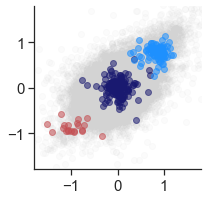

In [40]:
Mean_squared_error_pepplot = 0.1

df_Plot_background = combined_SILAC.loc[(combined_SILAC['mean_sqr_error_2'] < Mean_squared_error_pepplot) &
                             (combined_SILAC['mean_sqr_error_3'] < Mean_squared_error_pepplot)]


df_Plot_protein_1 = df_Plot_background.loc[df_Plot_background['Protein'].str.contains('H2B2')]
df_Plot_protein_2 = df_Plot_background.loc[df_Plot_background['Protein'].str.contains('RPB1_')]
df_Plot_protein_3 = df_Plot_background.loc[df_Plot_background['Protein'].str.contains('CISY1')]
                   

sns.set(rc={'figure.figsize':(3,3)})
sns.set_style('ticks')

sns.regplot(x='slope_2', y='slope_3', data=df_Plot_background, 
            fit_reg=False, scatter_kws={'alpha':.075}, color = 'lightgray')

sns.regplot(x='slope_2', y='slope_3', data=df_Plot_protein_1, 
            fit_reg=False, scatter_kws={'alpha':.55}, color = color_1)

sns.regplot(x='slope_2', y='slope_3', data=df_Plot_protein_2, 
            fit_reg=False, scatter_kws={'alpha':.55}, color = color_2)

sns.regplot(x='slope_2', y='slope_3', data=df_Plot_protein_3, 
            fit_reg=False, scatter_kws={'alpha':.55}, color = color_3)



sns.set(rc={'figure.figsize':(3,3)})
sns.set_style('ticks')
plt.xlabel("")
plt.ylabel("")
plt.tick_params(labelsize= 15)
plt.ylim([-1.8, 1.8])
plt.xlim([-1.8, 1.8])
sns.despine()
plt.savefig('peptide_slopes_example.pdf', dp1=300, bbox_inches='tight')

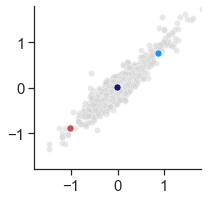

In [41]:
df_Plot_protein = Protein_df_fit


Protein_df_fit_plot = df_Plot_protein.loc[(df_Plot_protein['slope_2'] > 3)
                                         & (df_Plot_protein['slope_3'] > 3)]

df_Plot_protein_1 = Protein_df_fit_plot.loc[Protein_df_fit_plot.index.str.contains('H2B2')]
df_Plot_protein_2 = Protein_df_fit_plot.loc[Protein_df_fit_plot.index.str.contains('RPB1_')]
df_Plot_protein_3 = Protein_df_fit_plot.loc[Protein_df_fit_plot.index.str.contains('CISY1')]
   


sns.scatterplot(data=Protein_df_fit_plot, x='slope_2_ProtCalc', y='slope_3_ProtCalc', 
                alpha=0.50, legend=False, color = 'lightgray')

sns.scatterplot(data=df_Plot_protein_1, x='slope_2_ProtCalc', y='slope_3_ProtCalc', 
                alpha=1, legend=False, color = color_1, s=50)

sns.scatterplot(data=df_Plot_protein_2, x='slope_2_ProtCalc', y='slope_3_ProtCalc', 
                alpha=1, legend=False, color = color_2, s=50)

sns.scatterplot(data=df_Plot_protein_3, x='slope_2_ProtCalc', y='slope_3_ProtCalc', 
                alpha=1, legend=False, color = color_3, s=50)




sns.set(rc={'figure.figsize':(3,3)})
sns.set_style('ticks')
plt.xlabel("")
plt.ylabel("")
plt.tick_params(labelsize= 15)
plt.ylim([-1.8, 1.8])
plt.xlim([-1.8, 1.8])
sns.despine()
plt.savefig('protein_slopes_example.pdf', dp1=300, bbox_inches='tight')

In [42]:
#
# Peptide Plots for selected proteins
#

In [43]:
sns.set(rc={'figure.figsize':(1.9,3.5)})
tick_size = 12
ylim_low = 0.25
ylim_high = 1.75
tick_size = 19

40


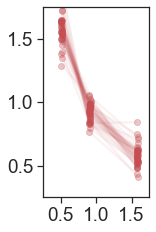

In [44]:
#regplots for specific proteins

df_Protein = df_1_8.loc[(df_1_8['Leading razor protein'].str.contains('H2B2'))
                      & (df_1_8['mean_sqr_error'] < 0.1)]

# df_Protein = df_1_8.loc[(df_1_8['Leading razor protein'] == 'sp|P52292|IMA1_HUMAN')
#                       & (df_1_8['mean_sqr_error'] < 1)]



sns.set_style('ticks')
for index, row in df_Protein.iterrows():
    x = [0.51, .91, 1.58]
    y = [row['Normalized_IntensityFraction_M'], 
         row['Normalized_IntensityFraction_L'], 
         row['Normalized_IntensityFraction_H']]
    g = sns.regplot(x=x,y=y, fit_reg=True, ci=False, scatter_kws={'alpha':0.3}, 
                line_kws={'alpha':0.07}, lowess=True, color = color_1, x_jitter = 0.01)

g.set_xticks([0.5,1,1.5])
g.set_yticks([0.5,1,1.5])
plt.tick_params(labelsize= tick_size)
# plt.tick_params(labelsize= tick_size)
plt.xlabel("")
plt.ylabel("")  
plt.ylim([ylim_low, ylim_high])
plt.xlim([0.25, 1.75])

print(len(df_Protein))
plt.savefig('peps_H2B_1.pdf', dp1=300, bbox_inches='tight')

46


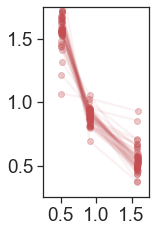

In [45]:
#regplots for specific proteins

df_Protein = df_2_8.loc[(df_2_8['Leading razor protein'].str.contains('H2B2'))
                      & (df_2_8['mean_sqr_error'] < 0.1)]

# df_Protein = df_1_8.loc[(df_1_8['Leading razor protein'] == 'sp|P52292|IMA1_HUMAN')
#                       & (df_1_8['mean_sqr_error'] < 1)]



sns.set_style('ticks')
for index, row in df_Protein.iterrows():
    x = [0.51, .91, 1.58]
    y = [row['Normalized_IntensityFraction_L'], 
         row['Normalized_IntensityFraction_H'], 
         row['Normalized_IntensityFraction_M']]
    g = sns.regplot(x=x,y=y, fit_reg=True, ci=False, scatter_kws={'alpha':0.3}, 
                line_kws={'alpha':0.07}, lowess=True, color = color_1, x_jitter = 0.01)

g.set_xticks([0.5,1,1.5])
g.set_yticks([0.5,1,1.5])
plt.tick_params(labelsize= tick_size)
# plt.tick_params(labelsize= tick_size)
plt.xlabel("")
plt.ylabel("")  
plt.ylim([ylim_low, ylim_high])
plt.xlim([0.25, 1.75])

print(len(df_Protein))
plt.savefig('peps_H2B_2.pdf', dp1=300, bbox_inches='tight')

28


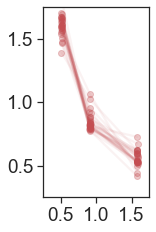

In [46]:
#regplots for specific proteins

df_Protein = df_3_8.loc[(df_3_8['Leading razor protein'].str.contains('H2B2'))
                      & (df_3_8['mean_sqr_error'] < 0.1)]

# df_Protein = df_1_8.loc[(df_1_8['Leading razor protein'] == 'sp|P52292|IMA1_HUMAN')
#                       & (df_1_8['mean_sqr_error'] < 1)]



sns.set_style('ticks')
for index, row in df_Protein.iterrows():
    x = [0.51, .91, 1.58]
    y = [row['Normalized_IntensityFraction_H'], 
         row['Normalized_IntensityFraction_M'], 
         row['Normalized_IntensityFraction_L']]
    g = sns.regplot(x=x,y=y, fit_reg=True, ci=False, scatter_kws={'alpha':0.3}, 
                line_kws={'alpha':0.07}, lowess=True, color = color_1, x_jitter = 0.01)

g.set_xticks([0.5,1,1.5])
g.set_yticks([0.5,1,1.5])
plt.tick_params(labelsize= tick_size)
# plt.tick_params(labelsize= tick_size)
plt.xlabel("")
plt.ylabel("")  
plt.ylim([ylim_low, ylim_high])
plt.xlim([0.25, 1.75])

print(len(df_Protein))
plt.savefig('peps_H2B_3.pdf', dp1=300, bbox_inches='tight')

202


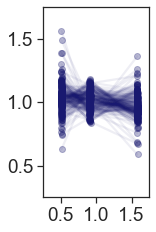

In [47]:
#regplots for specific proteins

df_Protein = df_1_8.loc[(df_1_8['Leading razor protein'].str.contains('RPB1_'))
                      & (df_1_8['mean_sqr_error'] < 0.1)]

# df_Protein = df_1_8.loc[(df_1_8['Leading razor protein'] == 'sp|P52292|IMA1_HUMAN')
#                       & (df_1_8['mean_sqr_error'] < 1)]



sns.set_style('ticks')
for index, row in df_Protein.iterrows():
    x = [0.51, .91, 1.58]
    y = [row['Normalized_IntensityFraction_M'], 
         row['Normalized_IntensityFraction_L'], 
         row['Normalized_IntensityFraction_H']]
    g = sns.regplot(x=x,y=y, fit_reg=True, ci=False, scatter_kws={'alpha':0.3}, 
                line_kws={'alpha':0.07}, lowess=True, color = color_2, x_jitter = 0.01)

g.set_xticks([0.5,1,1.5])
g.set_yticks([0.5,1,1.5])
plt.tick_params(labelsize= tick_size)
# plt.tick_params(labelsize= tick_size)
plt.xlabel("")
plt.ylabel("")  
plt.ylim([ylim_low, ylim_high])
plt.xlim([0.25, 1.75])

print(len(df_Protein))
plt.savefig('peps_RPB1_1.pdf', dp1=300, bbox_inches='tight')

223


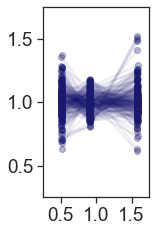

In [48]:
#regplots for specific proteins

df_Protein = df_2_8.loc[(df_2_8['Leading razor protein'].str.contains('RPB1_'))
                      & (df_2_8['mean_sqr_error'] < 0.1)]

# df_Protein = df_1_8.loc[(df_1_8['Leading razor protein'] == 'sp|P52292|IMA1_HUMAN')
#                       & (df_1_8['mean_sqr_error'] < 1)]



sns.set_style('ticks')
for index, row in df_Protein.iterrows():
    x = [0.51, .91, 1.58]
    y = [row['Normalized_IntensityFraction_L'], 
         row['Normalized_IntensityFraction_H'], 
         row['Normalized_IntensityFraction_M']]
    g = sns.regplot(x=x,y=y, fit_reg=True, ci=False, scatter_kws={'alpha':0.3}, 
                line_kws={'alpha':0.07}, lowess=True, color = color_2, x_jitter = 0.01)

g.set_xticks([0.5,1,1.5])
g.set_yticks([0.5,1,1.5])
plt.tick_params(labelsize= tick_size)
# plt.tick_params(labelsize= tick_size)
plt.xlabel("")
plt.ylabel("")  
plt.ylim([ylim_low, ylim_high])
plt.xlim([0.25, 1.75])

print(len(df_Protein))
plt.savefig('peps_RPB1_2.pdf', dp1=300, bbox_inches='tight')

239


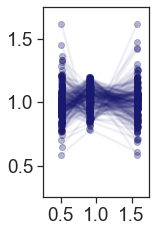

In [49]:
#regplots for specific proteins

df_Protein = df_3_8.loc[(df_3_8['Leading razor protein'].str.contains('RPB1_'))
                      & (df_3_8['mean_sqr_error'] < 0.1)]

# df_Protein = df_1_8.loc[(df_1_8['Leading razor protein'] == 'sp|P52292|IMA1_HUMAN')
#                       & (df_1_8['mean_sqr_error'] < 1)]



sns.set_style('ticks')
for index, row in df_Protein.iterrows():
    x = [0.51, .91, 1.58]
    y = [row['Normalized_IntensityFraction_H'], 
         row['Normalized_IntensityFraction_M'], 
         row['Normalized_IntensityFraction_L']]
    g = sns.regplot(x=x,y=y, fit_reg=True, ci=False, scatter_kws={'alpha':0.3}, 
                line_kws={'alpha':0.07}, lowess=True, color = color_2, x_jitter = 0.01)

g.set_xticks([0.5,1,1.5])
g.set_yticks([0.5,1,1.5])
plt.tick_params(labelsize= tick_size)
# plt.tick_params(labelsize= tick_size)
plt.xlabel("")
plt.ylabel("")  
plt.ylim([ylim_low, ylim_high])
plt.xlim([0.25, 1.75])

print(len(df_Protein))
plt.savefig('peps_RPB1_3.pdf', dp1=300, bbox_inches='tight')

163


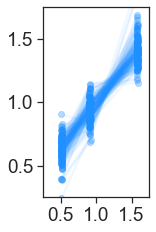

In [50]:
#regplots for specific proteins

df_Protein = df_1_8.loc[(df_1_8['Leading razor protein'].str.contains('CISY1'))
                      & (df_1_8['mean_sqr_error'] < 0.1)]

# df_Protein = df_1_8.loc[(df_1_8['Leading razor protein'] == 'sp|P52292|IMA1_HUMAN')
#                       & (df_1_8['mean_sqr_error'] < 1)]



sns.set_style('ticks')
for index, row in df_Protein.iterrows():
    x = [0.51, .91, 1.58]
    y = [row['Normalized_IntensityFraction_M'], 
         row['Normalized_IntensityFraction_L'], 
         row['Normalized_IntensityFraction_H']]
    g = sns.regplot(x=x,y=y, fit_reg=True, ci=False, scatter_kws={'alpha':0.3}, 
                line_kws={'alpha':0.07}, lowess=True, color = color_3, x_jitter = 0.01)

g.set_xticks([0.5,1,1.5])
g.set_yticks([0.5,1,1.5])
plt.tick_params(labelsize= tick_size)
# plt.tick_params(labelsize= tick_size)
plt.xlabel("")
plt.ylabel("")  
plt.ylim([ylim_low, ylim_high])
plt.xlim([0.25, 1.75])

print(len(df_Protein))
plt.savefig('peps_CIT1_1.pdf', dp1=300, bbox_inches='tight')

173


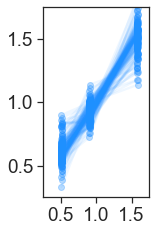

In [51]:
#regplots for specific proteins

df_Protein = df_2_8.loc[(df_2_8['Leading razor protein'].str.contains('CISY1'))
                      & (df_2_8['mean_sqr_error'] < 0.1)]

# df_Protein = df_1_8.loc[(df_1_8['Leading razor protein'] == 'sp|P52292|IMA1_HUMAN')
#                       & (df_1_8['mean_sqr_error'] < 1)]



sns.set_style('ticks')
for index, row in df_Protein.iterrows():
    x = [0.51, .91, 1.58]
    y = [row['Normalized_IntensityFraction_L'], 
         row['Normalized_IntensityFraction_H'], 
         row['Normalized_IntensityFraction_M']]
    g = sns.regplot(x=x,y=y, fit_reg=True, ci=False, scatter_kws={'alpha':0.3}, 
                line_kws={'alpha':0.07}, lowess=True, color = color_3, x_jitter = 0.01)

g.set_xticks([0.5,1,1.5])
g.set_yticks([0.5,1,1.5])
plt.tick_params(labelsize= tick_size)
# plt.tick_params(labelsize= tick_size)
plt.xlabel("")
plt.ylabel("")  
plt.ylim([ylim_low, ylim_high])
plt.xlim([0.25, 1.75])

print(len(df_Protein))
plt.savefig('peps_CIT1_2.pdf', dp1=300, bbox_inches='tight')

144


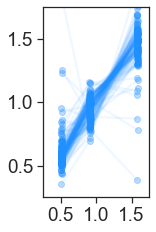

In [52]:
#regplots for specific proteins

df_Protein = df_3_8.loc[(df_3_8['Leading razor protein'].str.contains('CISY1'))
                      & (df_3_8['mean_sqr_error'] < 0.1)]

# df_Protein = df_1_8.loc[(df_1_8['Leading razor protein'] == 'sp|P52292|IMA1_HUMAN')
#                       & (df_1_8['mean_sqr_error'] < 1)]



sns.set_style('ticks')
for index, row in df_Protein.iterrows():
    x = [0.51, .91, 1.58]
    y = [row['Normalized_IntensityFraction_H'], 
         row['Normalized_IntensityFraction_M'], 
         row['Normalized_IntensityFraction_L']]
    g = sns.regplot(x=x,y=y, fit_reg=True, ci=False, scatter_kws={'alpha':0.3}, 
                line_kws={'alpha':0.07}, lowess=True, color = color_3, x_jitter = 0.01)

g.set_xticks([0.5,1,1.5])
g.set_yticks([0.5,1,1.5])
plt.tick_params(labelsize= tick_size)
# plt.tick_params(labelsize= tick_size)
plt.xlabel("")
plt.ylabel("")  
plt.ylim([ylim_low, ylim_high])
plt.xlim([0.25, 1.75])

print(len(df_Protein))
plt.savefig('peps_CIT1_3.pdf', dp1=300, bbox_inches='tight')